# LRP

Implementation of Layer-wise Relevance Propagation (LRP) in PyTorch.

In [1]:
import myutils
img = myutils.load_normalized_img('castle.jpg')
X = myutils.img_to_tensor(img)

import torchvision
model = torchvision.models.vgg16(pretrained=True)
model.eval()

import utils
import torch

In [2]:
import copy

# Parameter modifier
# max(0, *)
positive_contributions = lambda p: p.clamp(min=0)
# min(0, *)
negative_contributions = lambda p: p.clamp(max=0)

# Build an equivalent forward pass where part of it is detached
class ZeroEpsilonGammaConv(torch.nn.Module):

  def __init__(self, conv, epsilon=0, gamma=0):
    torch.nn.Module.__init__(self)
    self.epsilon = epsilon
    self.conv = conv
    # p stands for processed
    self.pconv = copy.deepcopy(conv)
    self.pconv.weight = torch.nn.Parameter(conv.weight + gamma * positive_contributions(conv.weight))
    self.pconv.bias = torch.nn.Parameter(conv.bias + gamma * positive_contributions(conv.bias))

  def forward(self, X):
    z = self.conv.forward(X)
    zp = self.epsilon + self.pconv.forward(X)
    # The additive term 1e-9 enforces 0/0 = 0 (numerical stability)
    return zp * (z / (zp + 1e-9)).detach()
    # return zp * (z / zp).detach()

In [3]:

import torch
from myutils import ILSVRC2012_BatchNormalize
batch_size = 1
shape = (batch_size, 3, 224, 224)
norm_fn = ILSVRC2012_BatchNormalize()
low = norm_fn(torch.zeros(*shape))
high = norm_fn(torch.ones(*shape))

class ZBConv(torch.nn.Module):

  def __init__(self, conv, low, high):
    torch.nn.Module.__init__(self)
    self.conv = conv
    self.low = low
    self.high = high
    self.low.requires_grad = True
    self.high.requires_grad = True
    
    self.low_conv = copy.deepcopy(conv)
    self.high_conv = copy.deepcopy(conv)

    self.low_conv.weight = torch.nn.Parameter(positive_contributions(conv.weight))
    self.low_conv.bias = torch.nn.Parameter(positive_contributions(conv.bias))

    self.high_conv.weight = torch.nn.Parameter(negative_contributions(conv.weight))
    self.high_conv.bias = torch.nn.Parameter(negative_contributions(conv.bias))

  def forward(self, X):
    z_conv = self.conv.forward(X)
    z_low = self.low_conv.forward(self.low)
    z_high = self.high_conv.forward(self.high)

    z = z_conv - z_low - z_high

    return z * (z_conv / (z + 1e-9)).detach()

In [4]:
class LRP():
  def __init__(self, model) -> None:
      self.model = model
      self.model.eval()

  def convert_single_layer(self, i, layer, classifier=False):
    if i == 0 and not classifier:
      # First layer is the pixel layer
      # return layer
      return ZBConv(layer, low=low, high=high)
      
    # # Source: lrp-tutorial
    # if isinstance(layers[l],torch.nn.MaxPool2d):
    #   layers[l] = torch.nn.AvgPool2d(2)
    #
    # if isinstance(layer, torch.nn.MaxPool2d):
    #   layer = ZeroEpsilonGammaConv(layer, gamma)

    # Case: bottom layers, apply LRP-Gamma with gamma = 0.25
    if i <= 16: gamma = 0.25; epsilon = 0

    # Case: middle layers, apply LRP-Epsilon with epsilon = 0.25. Alt. 1e-6
    if 17 <= i <= 30: gamma = 0; epsilon = 0.25

    # Case: top layers, apply LRP-0
    if i >= 31: gamma = 0; epsilon = 0

    if isinstance(layer, torch.nn.Conv2d):
      return ZeroEpsilonGammaConv(layer, epsilon=epsilon, gamma=gamma)
    
    return layer

  def convert_layers(self):
    for i, layer in enumerate(self.model.features):
      self.model.features[i] = self.convert_single_layer(i, layer)

    # self.model.avgpool = self.convert_single_layer(31, layer)
    
    for i, layer in enumerate(self.model.classifier):
      self.model.classifier[i] = self.convert_single_layer(i, layer, classifier=True)

  def relevance(self, X):
    # Apply Gradient x Input
    # Prepare to compute input gradient

    # Reset gradient
    self.model.zero_grad()
    X.requires_grad = True

    # Compute explanation
    # Stores value of gradient in X.grad
    # [0].max() retrieves the maximum activation/relevance in the first layer
    # = 483 for castle
    self.model.forward(X)[0].max().backward()

    # Retrieve gradients from first layer
    first_layer = self.model.features[0]
    l = first_layer.low
    h = first_layer.high
    
    # Calculate gradients
    c1, c2, c3 = X.grad, l.grad, h.grad

    # Calculate relevance
    self.R = X*c1 + l*c2 + h*c3
    return self.R

  def visualize(self):
    utils.heatmap(self.R[0].sum(dim=0).detach().numpy(), 4,4)

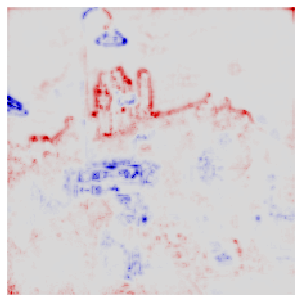

In [5]:
lrp = LRP(model)
lrp.convert_layers()
lrp.relevance(X)
lrp.visualize()

# ToDo:

- Extend mapping to classification layers (model.children or model.modules)
- Apply different rules by layer type and index
Source: https://github.com/adrhill/ExplainabilityMethods.jl/blob/0a9ca79d75525f99eb59a5d54bc7b0e7486ac614/src/lrp_rules.jl#L84-L88

## Automation

- Automate modifying the parameters of the model (named_parameters(), see zennit)
- Looping through layers of model (children, modules)

--- 

## Hard

- Canonize models
- Convert MaxPooling2D to AvgPooling2D

